In [ ]:
import os

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip
!rm celeba-dataset.zip

kaggle.json
 17% 236M/1.33G [00:02<00:11, 107MB/s] 
User cancelled operation
[celeba-dataset.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of celeba-dataset.zip or
        celeba-dataset.zip.zip, and cannot find celeba-dataset.zip.ZIP, period.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization
from keras.initializers import RandomNormal
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn, randint
import tensorflow as tf

### Loading the data

In [ ]:
n_images = 10000
batch_size = 128 # so we don't run out of memory
latent_dim = 100
epochs = 100
img_shape = (128, 128, 3) # 128x128 images

Get the filenames

In [ ]:
image_directory = '/content/img_align_celeba/img_align_celeba/' 
image_paths = os.listdir(image_directory)
image_paths = image_paths[:n_images]

Load the images

In [ ]:
def get_images(image_paths):
    images = []
    for filename in image_paths:
        img = img_to_array(load_img(image_directory + "/" + filename, target_size = img_shape[:2]))
        images.append(img)
    images = np.array(images).astype('float32')
    images = (images - 127.5) / 127.5
    return images

images = get_images(image_paths)

### Training the models
Discriminator model

In [5]:
def define_discriminator(in_shape=(128, 128, 3)):
    model = Sequential()
    # start with 128x128
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 64x64
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 32x32
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 16x16
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # flatten for classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Generator model

In [4]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation 8x8
    n_nodes = 128 * 8 * 8
    init = RandomNormal(mean=0.0, stddev=0.02)
    model.add(Dense(n_nodes, input_dim=latent_dim, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))

    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # output layer will be 128x128x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

# generate points from the latent space
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate latent points
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

Building the GAN

In [3]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated, epoch, n=5):
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        #img = plt.imread(data_dir + '/' + name)
        plt.imshow(generated[i])
        #plt.title(name)
        plt.axis('off')
    plt.savefig('faces_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

Evalulating the model

In [ ]:
# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):

    # get n real images
    X_real, y_real = get_real_samples(dataset, n_samples)

    # evaluate the discriminator on the real images
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # generate n fake images
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

    # evaluate discriminator on the fake images
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # summarize the overall performance
    print('Accuracy - real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    # show plot
    show_generated(x_fake, epoch)    

### Training the model


In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, epochs=100, batch_size=128):
    generator_losses = []
    discriminator_losses = []

    batches_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # manually enumerate epochs
    start = time.time()
    for i in range(epochs):
        
        # enumerate batches over the training set
        for j in range(batches_per_epoch):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, batch_size)
            # create inverted labels for the fake samples
            y_gan = np.ones((batch_size, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
        generator_losses.append(g_loss)
        discriminator_losses.append(d_loss1 + d_loss2)
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        # evaluate the model performance
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
    return generator_losses, discriminator_losses      

In [9]:
# GAN architecture
generator = define_generator(100)
generator.summary()
discriminator = define_discriminator()
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 128)      

Run the model

In [ ]:
# make a new discriminator and generator model
# it is better to do it this way because we can modularly change both model definitions
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# initialise the gan
gan = define_gan(generator, discriminator)

# train the model
generator_losses, discriminator_losses = train(generator, discriminator, gan, images, latent_dim, epochs, batch_size)

Output hidden; open in https://colab.research.google.com to view.

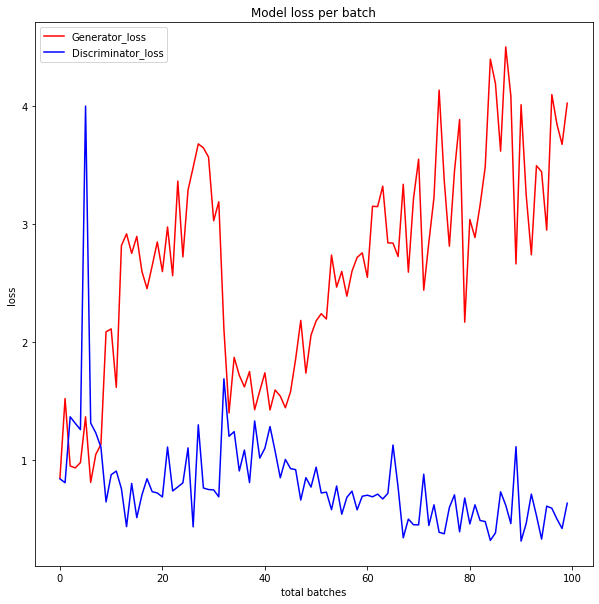

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(losses['G'],color='red',label='Generator_loss')
plt.plot(losses['discriminator'],color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()